In [1]:
import sys,os
import setGPU
import numpy as np
import random
import h5py

from sklearn.metrics import silhouette_score,davies_bouldin_score,calinski_harabasz_score
import sklearn
from sklearn.metrics import confusion_matrix
from scipy.sparse import csr_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from pathlib import Path
from importlib import reload  
import os.path as osp
sys.path.append(os.path.abspath(os.path.join('../IDEC/')))
import data_utils.data_processing as data_proc
from data_utils.data_processing import GraphDataset, DenseEventDataset
from training_utils.metrics import cluster_acc
from models.models import DenseAE, IDEC 
from training_utils.training import pretrain_ae_dense,train_test_ae_dense,train_test_idec_dense, target_distribution
from training_utils.activation_funcs  import get_activation_func

from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.data import Data, Batch, DataLoader
from data_utils.data_processing import GraphDataset,DenseEventDataset
from training_utils.metrics import cluster_acc

import torch
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score
from torch.utils.data import DataLoader as DataLoaderTorch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

setGPU: Setting GPU to: 0


In [11]:
DATA_PATH = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/autoencoder_for_anomaly/clustering/inputs/'
#TRAIN_NAME = 'bkg_l1_filtered_1mln_padded.h5'
#TRAIN_NAME = 'bkg_sig_0.0156_l1_filtered_padded.h5'
TRAIN_NAME = 'bkg_sig_0.0156_l1_filtered_reduced.h5'

filename_bg = DATA_PATH + TRAIN_NAME 
in_file = h5py.File(filename_bg, 'r') 
file_dataset = np.array(in_file['dataset'])
random.shuffle(file_dataset)
file_dataset = file_dataset

#file_dataset_1d,dataset_proc_truth,dataset = data_proc.prepare_1d_datasets(file_dataset,n_top_proc = 3)
file_dataset_1d,_,dataset = data_proc.prepare_1d_reduced_datasets(file_dataset,n_top_proc =3)

#order_num_objets = [1,3,3,3,15,6]
#order_names_objects = 'met,e,g,mu,j,b'.split(',')
#feats = 'E,pt,eta,phi'.split(',')
num_feats = 4
order_num_objets = [1,1,1]
order_names_objects = 'met,egmu,j'.split(',')
feats = 'N,pt,eta,phi'.split(',')

access_idx = [0] #num_met_feats]
for n_obj in order_num_objets:
    access_idx.append(access_idx[-1]+num_feats*n_obj)

Preparing dataset, check that the feature indexing corresponds to your dataset!


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Thu/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Thu/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Thu/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


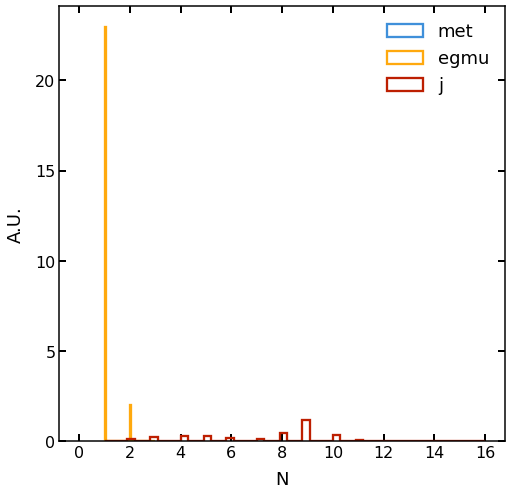

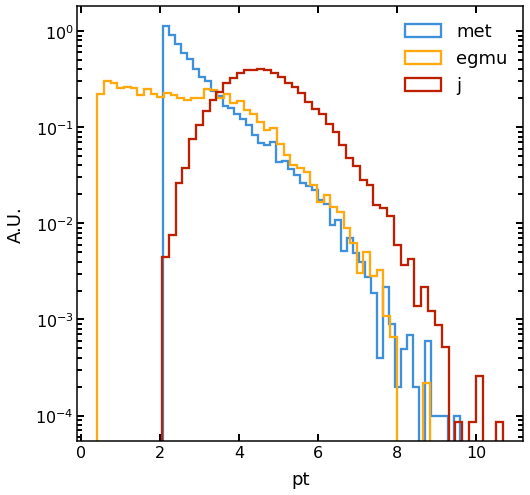

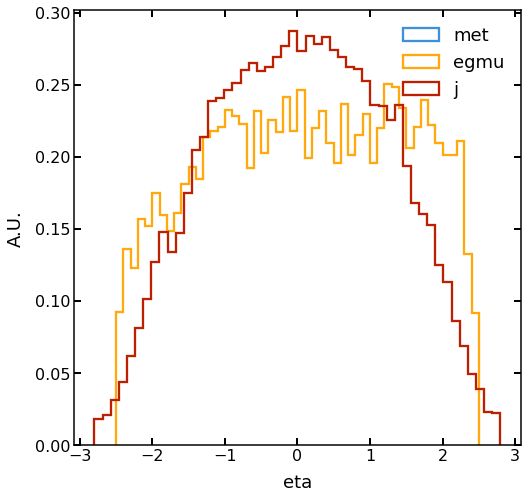

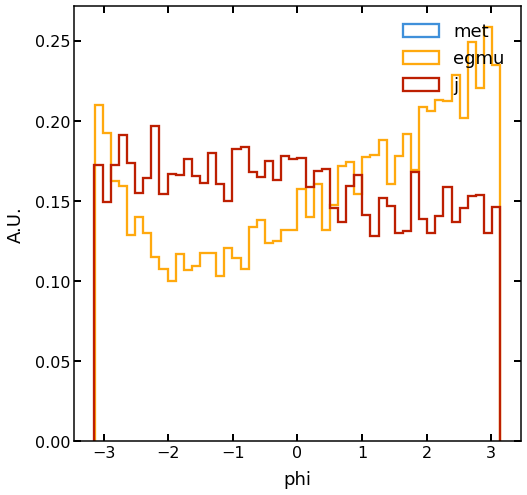

In [3]:
kwargs={'linewidth':2.3, 'fill':False, 'density':True,'histtype':'step'}
for i_feat,feat in enumerate(feats):
    plt.figure(figsize=(8,8))
    for i_obj,(obj,num_obj) in enumerate(zip(order_names_objects,order_num_objets)):
        data = file_dataset_1d[:,access_idx[i_obj]+i_feat:access_idx[i_obj]+num_obj*num_feats:num_feats]#start stop step
        mask = data!=0
        if feat=='E' or feat=='pt':
            bins = np.linspace(0,3,100)
        if feat=='eta':
            bins = np.linspace(-4,4,100)
       # elif i_obj==0:
       #     bins = np.linspace(0.9*np.min(data[mask]),1.1*np.max(data[mask]),100)
        _ = plt.hist(data[mask],bins=50,label=obj,**kwargs)
    plt.xlabel(feat)
    plt.ylabel('A.U.')
    plt.legend(loc='upper right')
    if feat=='E' or feat=='pt' : 
        plt.semilogy()
    #plt.semilogy()


In [8]:
import json 
import models.models as models
reload(models)
from models.models import load_DenseAE, load_IDEC, load_GraphAE 


load_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/autoencoder_for_anomaly/clustering/trained_output/dense/'
n_run = 'run_23'
load_dir+=n_run+'/'
#path_model_ae = load_dir+'/best_model_AE.pkl'
path_model_ae = load_dir+'/pretrained_AE_epoch_4.pkl'

#path_model_idec = load_dir+'best_model_IDEC.pkl'
path_model_idec = load_dir+'idec_model_epoch_11.pkl'
path_params = load_dir+'parameters.json'
params_dict = json.loads(json.load(open(path_params)))

model_AE = load_DenseAE(params_dict, device, path_model_ae)
model = load_IDEC(model_AE,params_dict, device, path_model_idec)


In [13]:
batch_size=256
test_loader = DataLoaderTorch(
        dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [14]:
#from IDEC 
num_clusters_dict = {}
num_cluster=3
    
latent_pred = []
true_labels = []
model.eval() 
    
pred_labels = np.array([model.forward(x.to(device))[2].data.cpu().numpy().argmax(1) for i,(x,_) in enumerate(test_loader)]) #argmax(1) ##index (cluster nubmber) of the cluster with the highest probability q.
latent_pred = np.array([model.forward(x.to(device))[3].data.cpu().numpy() for i,(x,_) in enumerate(test_loader)])
pred_features = np.array([model.forward(x.to(device))[0].data.cpu().numpy() for i,(x,_) in enumerate(test_loader)]) 
true_labels = np.array([y.cpu().numpy() for i,(_,y) in enumerate(test_loader)])
    
pred_labels = np.reshape(pred_labels,pred_labels.shape[0]*pred_labels.shape[1])
true_labels = np.reshape(true_labels,true_labels.shape[0]*true_labels.shape[1])
latent_pred = np.reshape(latent_pred,(latent_pred.shape[0]*latent_pred.shape[1],latent_pred.shape[2]))
pred_features = pred_features.reshape((pred_features.shape[0]*pred_features.shape[1],pred_features.shape[2]))
    
acc, nmi, ari,reassignment  = model.validateOnCompleteTestData(true_labels,pred_labels)

print('Acc {:.4f}'.format(acc),
        ', nmi {:.4f}'.format(nmi), ', ari {:.4f}'.format(ari))
predicted_reassigned = np.array([reassignment[item] for item in pred_labels])
    
#idx = np.random.choice(list(range(latent_pred.shape[0])), 20000)
#num_clusters_dict[num_cluster] = {}
#num_clusters_dict[num_cluster]['sil_score'] = silhouette_score(latent_pred[idx], predicted_reassigned[idx])
#num_clusters_dict[num_cluster]['db_score'] = davies_bouldin_score(latent_pred[idx], predicted_reassigned[idx])
#num_clusters_dict[num_cluster]['ch_score'] = calinski_harabasz_score(latent_pred[idx], predicted_reassigned[idx])

    

Acc 0.6913 , nmi 0.2816 , ari -0.5437


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Fri/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:389: RuntimeWarning: overflow encountered in long_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +


In [15]:
cmap = plt.cm.rainbow #rainbow
cmap = (colors.ListedColormap(['#5790fc', '#f89c20', '#e42536', '#964a8b'])
        .with_extremes(over='0.25', under='0.75'))
#norm = colors.BoundaryNorm(np.arange(1, 26, 1), cmap.N)
norm = colors.BoundaryNorm([0,9,12,25], cmap.N)
#norm = colors.BoundaryNorm([0,8.,  9., 12., 18., 19., 22.], cmap.N)


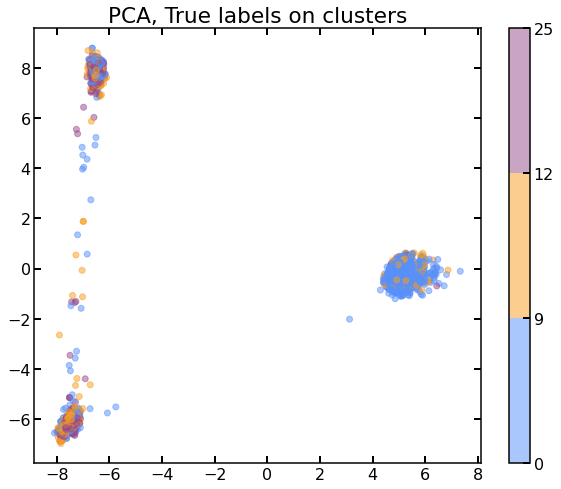

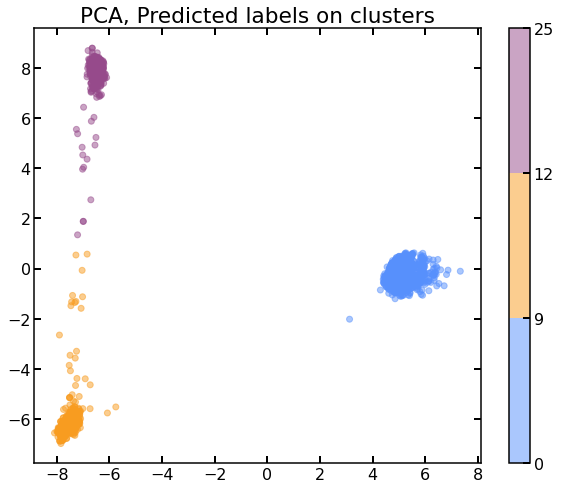

In [27]:

from sklearn.model_selection import StratifiedKFold

X = latent_pred
y = true_labels # subsamples will be stratified according to y
n_subsample = 5000
n = int(len(true_labels)/n_subsample)

skf = StratifiedKFold(n, shuffle = True)
for _, batch in skf.split(latent_pred, true_labels):
    break

#principalComponents = TSNE(n_components=2,verbose=1, perplexity=20, n_iter=1000, learning_rate=200
#                          ).fit_transform(latent_pred[batch])

pca = PCA(n_components=2)
#principalComponents = pca.fit_transform(np.array(latent_pred[batch]))
principalComponents = pca.fit_transform(np.array(latent_pred))

pc1 = principalComponents[:,0][batch]
pc2 = principalComponents[:,1][batch]

fig = plt.figure(figsize=(10,8))
plt.scatter(pc1,pc2, c=true_labels[batch],cmap=cmap, norm=norm, marker='o', alpha=0.5)
#plt.scatter(pc1,pc2, c=true_labels,cmap=cmap, norm=norm, marker='o', alpha=0.5)
plt.title('PCA, True labels on clusters')
cb = plt.colorbar()
#legend1 = plt.legend(*scatter.legend_elements(),
 #                   loc="upper left", title="Classes")

fig = plt.figure(figsize=(10,8))
plt.scatter(pc1,pc2, c=predicted_reassigned[batch],cmap=cmap, norm=norm, alpha=0.5)
#plt.scatter(pc1,pc2, c=predicted_reassigned,cmap=cmap, norm=norm, alpha=0.5)
plt.title('PCA, Predicted labels on clusters')
cb = plt.colorbar()

In [60]:
np.unique(true_labels)

array([ 7.,  8., 11., 17., 18., 21.], dtype=float32)

In [17]:
#From AE Only
latent_pred_ae = []
true_labels_ae = []
model_AE.eval() 
    
latent_pred_ae = np.array([model_AE.forward(x.to(device))[2].data.cpu().numpy() for i,(x,_) in enumerate(test_loader)])
pred_features_ae = np.array([model_AE.forward(x.to(device))[0].data.cpu().numpy() for i,(x,_) in enumerate(test_loader)]) 
true_labels_ae = np.array([y.cpu().numpy() for i,(_,y) in enumerate(test_loader)])
    
true_labels_ae = np.reshape(true_labels_ae,true_labels_ae.shape[0]*true_labels_ae.shape[1])
latent_pred_ae = np.reshape(latent_pred_ae,(latent_pred_ae.shape[0]*latent_pred_ae.shape[1],latent_pred_ae.shape[2]))
pred_features_ae = pred_features_ae.reshape((pred_features_ae.shape[0]*pred_features_ae.shape[1],pred_features_ae.shape[2]))
    


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Thu/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Thu/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


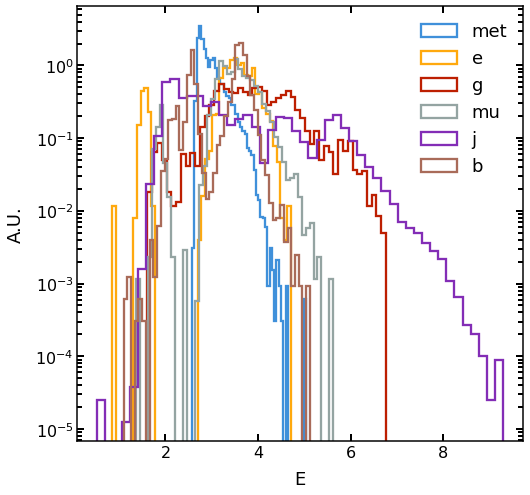

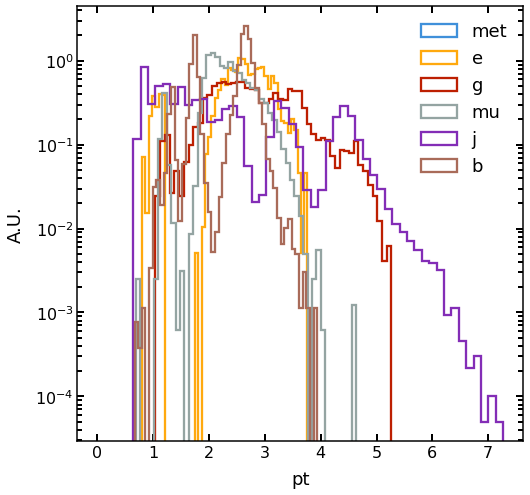

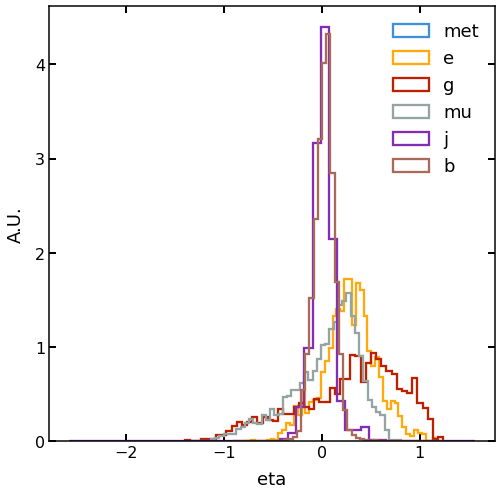

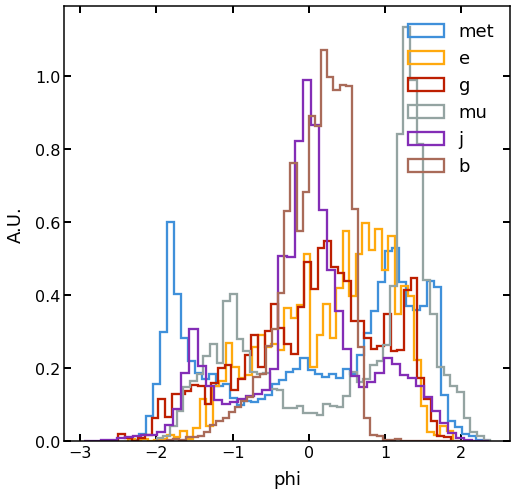

In [12]:
kwargs={'linewidth':2.3, 'fill':False, 'density':True,'histtype':'step'}
for i_feat,feat in enumerate(feats):
    plt.figure(figsize=(8,8))
    for i_obj,(obj,num_obj) in enumerate(zip(order_names_objects,order_num_objets)):
        data = pred_features[:,access_idx[i_obj]+i_feat:access_idx[i_obj]+num_obj*num_feats:num_feats]#start stop step
        mask = data!=0
        if feat=='E' or feat=='pt':
            bins = np.linspace(0,3,100)
        if feat=='eta':
            bins = np.linspace(-4,4,100)
       # elif i_obj==0:
       #     bins = np.linspace(0.9*np.min(data[mask]),1.1*np.max(data[mask]),100)
        _ = plt.hist(data[mask],bins=50,label=obj,**kwargs)
    plt.xlabel(feat)
    plt.ylabel('A.U.')
    plt.legend(loc='upper right')
    if feat=='E' or feat=='pt' : 
        plt.semilogy()
    #plt.semilogy()

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Thu/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Thu/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/tmp/ipykernel_2108/1455685645.py:21: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axs[i_feat].semilogy()
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Thu/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Thu/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide


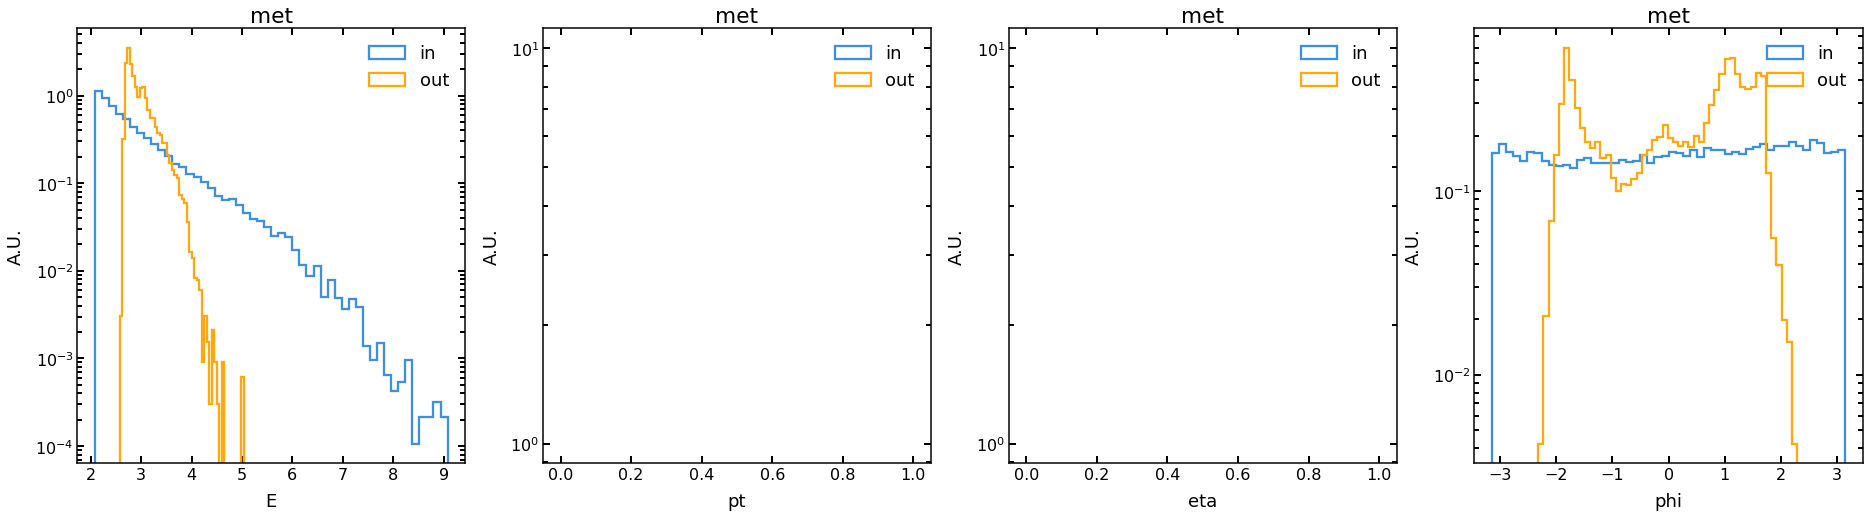

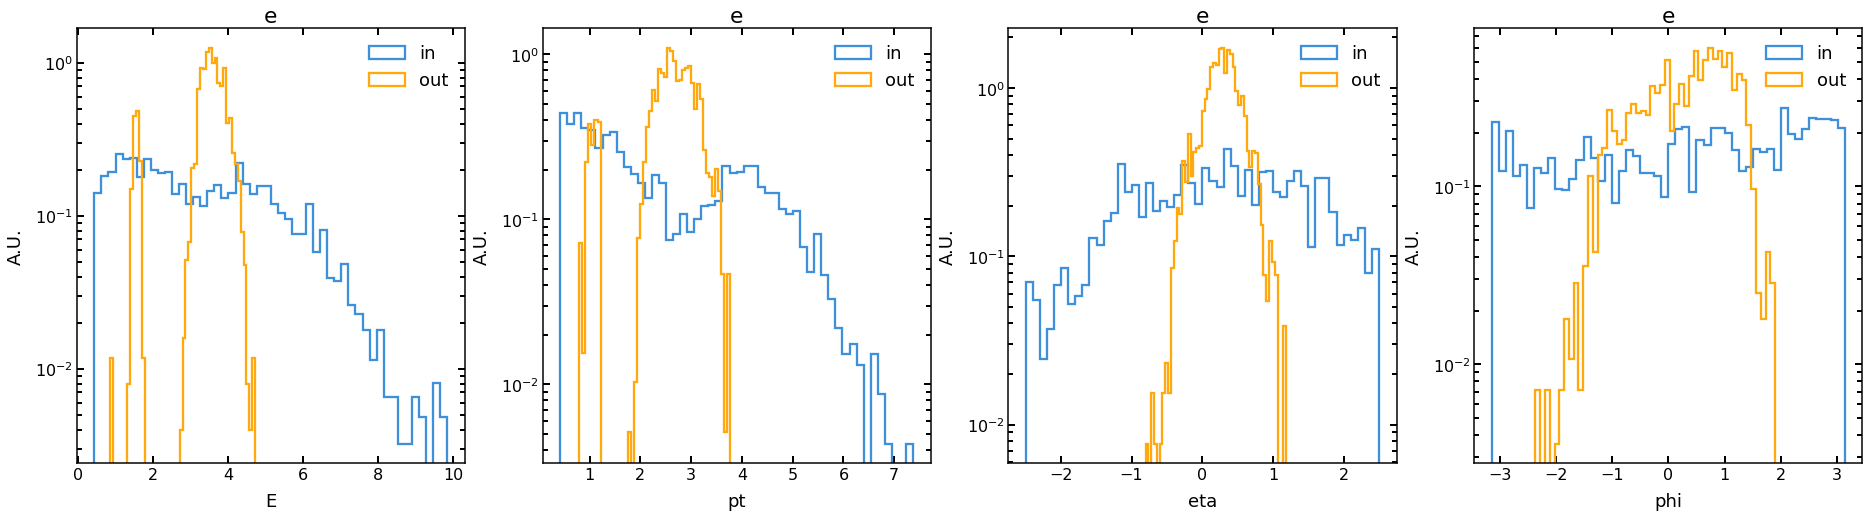

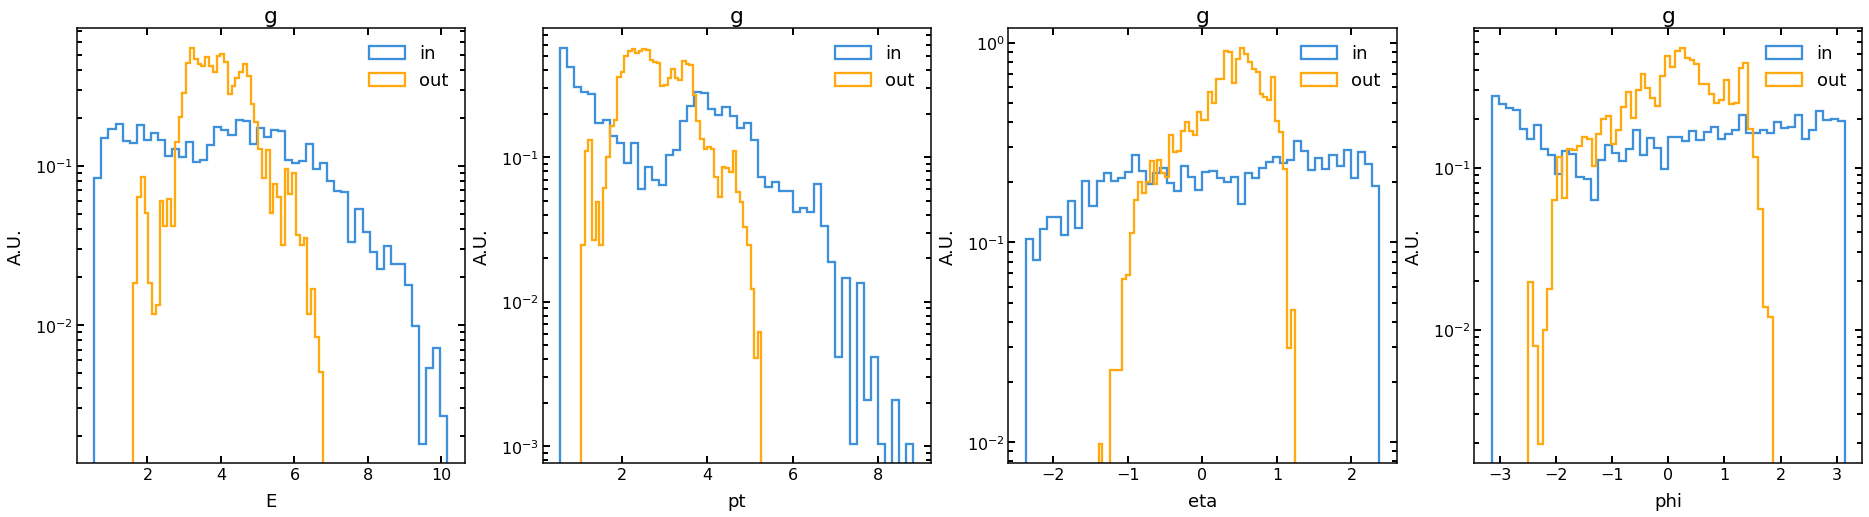

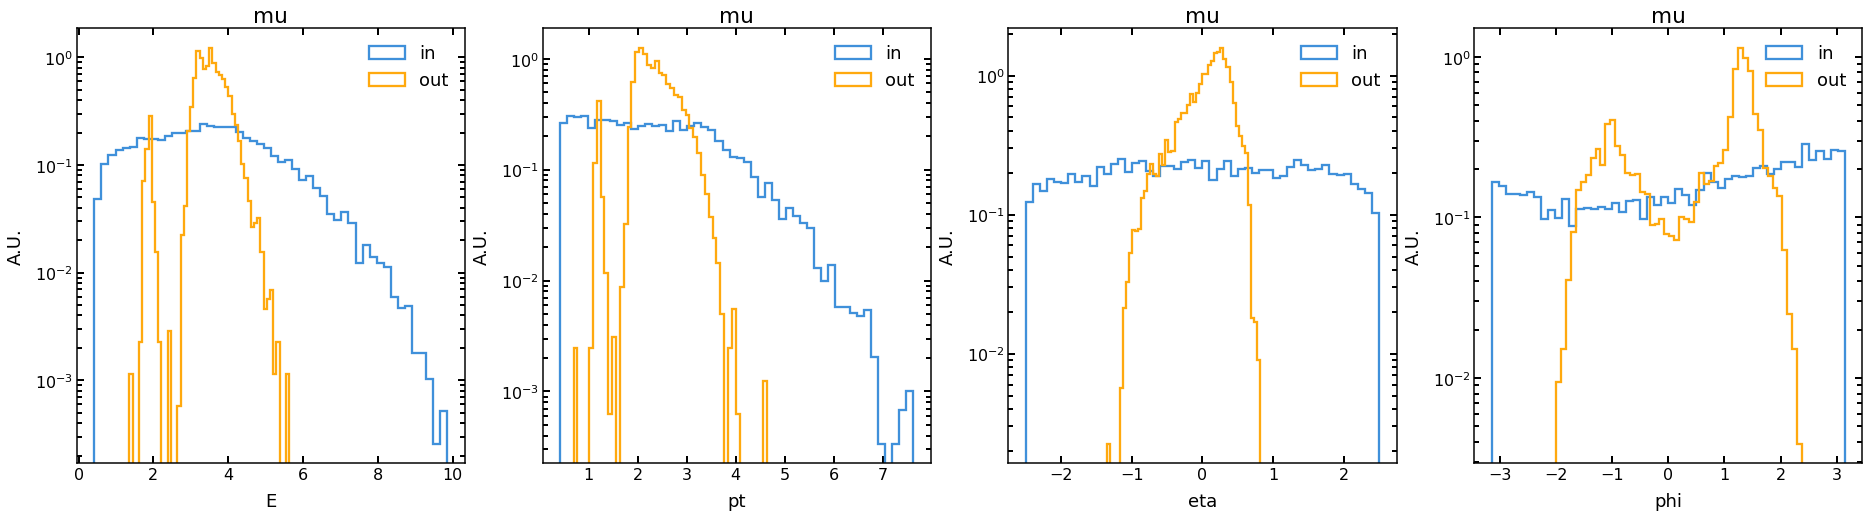

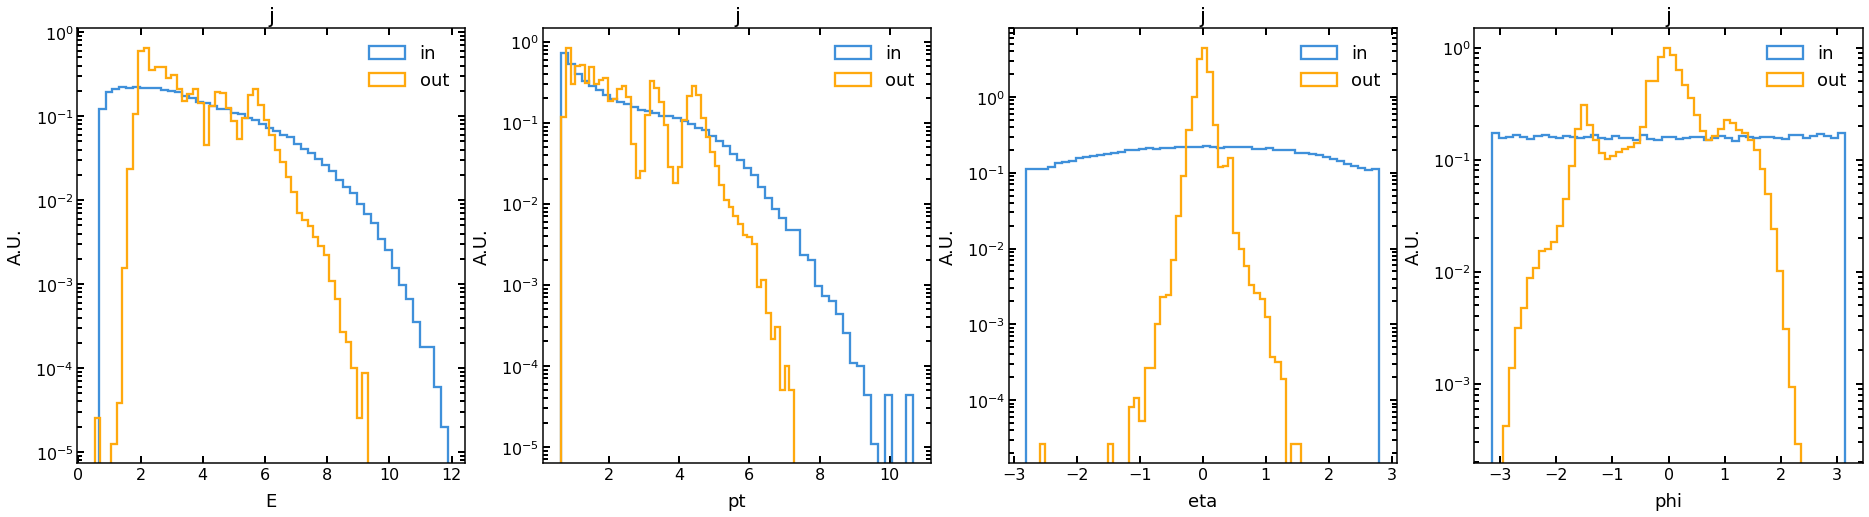

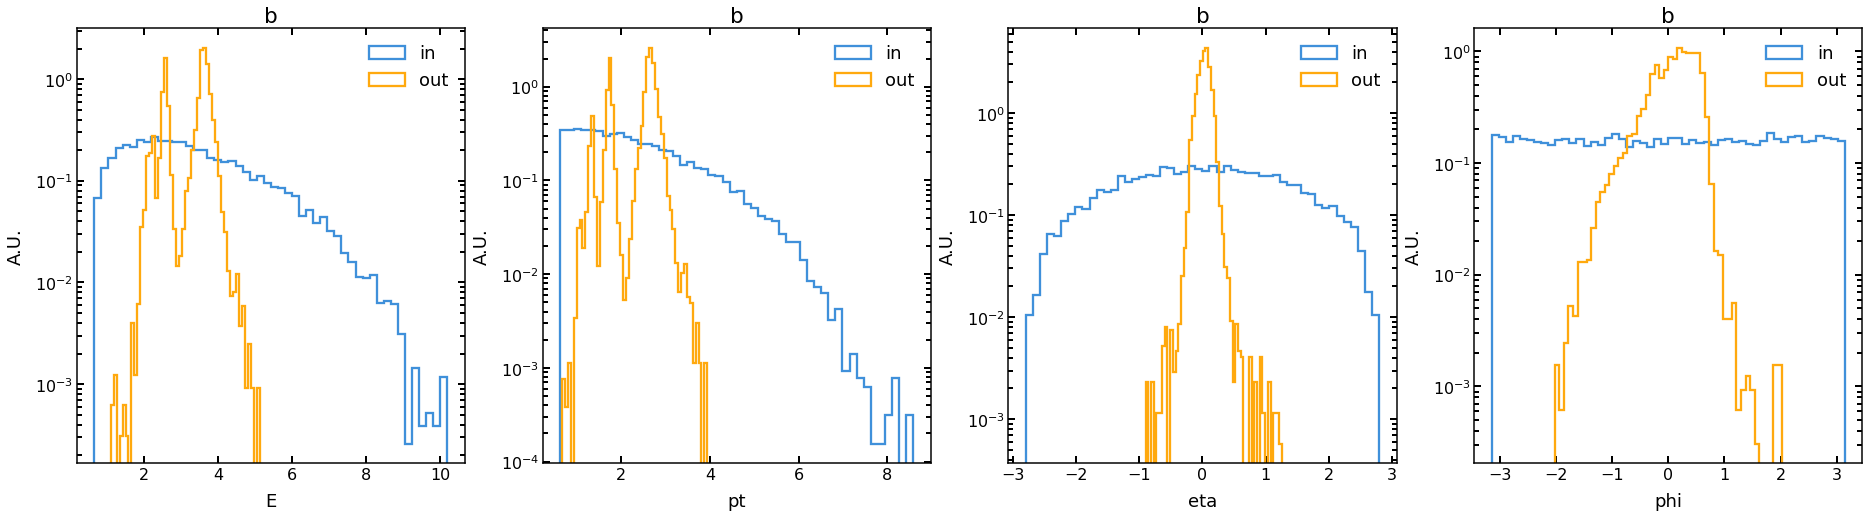

In [18]:
kwargs={'linewidth':2.3, 'fill':False, 'density':True,'histtype':'step'}
for i_obj,(obj,num_obj) in enumerate(zip(order_names_objects,order_num_objets)):
    fig,axs = plt.subplots(1,4,figsize=(32,8))
    axs=axs.reshape(-1)
    for i_feat,feat in enumerate(feats):
        data_true = file_dataset_1d[:,access_idx[i_obj]+i_feat:access_idx[i_obj]+num_obj*num_feats:num_feats]#start stop step
        mask_true = data_true!=0
        data_pred = pred_features_ae[:,access_idx[i_obj]+i_feat:access_idx[i_obj]+num_obj*num_feats:num_feats]#start stop step
        mask_pred = data_pred!=0
        if feat=='E' or feat=='pt':
            bins = np.linspace(0.,3.,100)
        if feat=='eta':
            bins = np.linspace(-4,4,30)
        _ = axs[i_feat].hist(data_true[mask_true],bins=50,label='in',**kwargs)
        _ = axs[i_feat].hist(data_pred[mask_pred],bins=50,label='out',**kwargs)
        axs[i_feat].set_title(obj)
        axs[i_feat].set_xlabel(feat)
        axs[i_feat].set_ylabel('A.U.')
        axs[i_feat].legend(loc='upper right')
        if feat=='E' or feat=='pt' : 
            axs[i_feat].semilogy()
        axs[i_feat].semilogy()

In [24]:

from sklearn.model_selection import StratifiedKFold

X = latent_pred
y = true_labels # subsamples will be stratified according to y
n_subsample = 5000
n = int(len(true_labels)/n_subsample)

skf = StratifiedKFold(n, shuffle = True)
for _, batch in skf.split(latent_pred_ae, true_labels):
    break

#principalComponents = TSNE(n_components=2,verbose=1, perplexity=20, n_iter=1000, learning_rate=200
#                          ).fit_transform(latent_pred[batch])

pca = PCA(n_components=2)
#principalComponents = pca.fit_transform(np.array(latent_pred[batch]))
principalComponents = pca.fit_transform(np.array(latent_pred_ae))

pc1 = principalComponents[:,0]#[batch]
pc2 = principalComponents[:,1]#[batch]


kmeans_initialized = KMeans(n_clusters=args.n_clusters, n_init=20)

fig = plt.figure(figsize=(10,8))
plt.scatter(pc1,pc2, c=true_labels,cmap=cmap, norm=norm, marker='o', alpha=0.5)
#plt.scatter(pc1,pc2, c=true_labels,cmap=cmap, norm=norm, marker='o', alpha=0.5)
plt.title('PCA, True labels on clusters')
cb = plt.colorbar()
#legend1 = plt.legend(*scatter.legend_elements(),
 #                   loc="upper left", title="Classes")


NameError: name 'args' is not defined

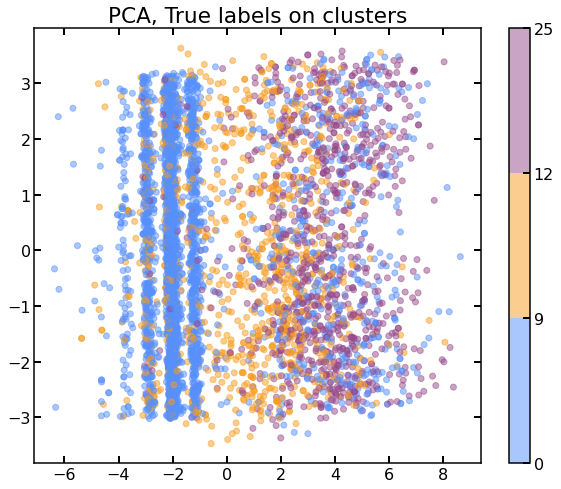

In [23]:
from sklearn.cluster import MiniBatchKMeans, KMeans

X = latent_pred
y = true_labels # subsamples will be stratified according to y
n_subsample = 5000
n = int(len(true_labels)/n_subsample)

skf = StratifiedKFold(n, shuffle = True)
x_feat = file_dataset_1d[:len(true_labels)]
for _, batch in skf.split(x_feat, true_labels):
    break

#principalComponents = TSNE(n_components=2,verbose=1, perplexity=20, n_iter=1000, learning_rate=200
#                          ).fit_transform(latent_pred[batch])

pca = PCA(n_components=2)
#principalComponents = pca.fit_transform(np.array(latent_pred[batch]))
principalComponents = pca.fit_transform(np.array(x_feat))

pc1 = principalComponents[:,0][batch]
pc2 = principalComponents[:,1][batch]


fig = plt.figure(figsize=(10,8))
plt.scatter(pc1,pc2, c=true_labels[batch],cmap=cmap, norm=norm, marker='o', alpha=0.5)
#plt.scatter(pc1,pc2, c=true_labels,cmap=cmap, norm=norm, marker='o', alpha=0.5)
plt.title('PCA, True labels on clusters')
cb = plt.colorbar()
#legend1 = plt.legend(*scatter.legend_elements(),
 #                   loc="upper left", title="Classes")


In [ ]:
file_dataset_1d